# Differential gene expression analysis in two brain regions

JuGEx performs differential gene expresssion in two different brain regions, as described in the publication

> *Sebastian Bludau, Thomas W. Mühleisen, Simon B. Eickhoff, Michael J. Hawrylycz, Sven Cichon, Katrin Amunts. Integration of transcriptomic and cytoarchitectonic data implicates a role for MAOA and TAC1 in the limbic-cortical network. 2018, Brain Structure and Function. https://doi.org/10.1007/s00429-018-1620-6*

For the gene expression data, `siibra` accesses the Allen Brain Atlas API (© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: brain-map.org/api/index.html). 

### Initialize the analysis

The analysis is initialized with a `siibra` atlas object. It will check if the parcellation selected in the atlas is suitable for performing the analysis, which includes to verify that the given atlas object provides maps in the MNI ICBM 152 space. We explicitely select the Julich-Brain probabilistic cytoarchitectonic maps, and  tell the atlas to threshold the probability maps for filtering gene expressions instead of using the simplified labelled volume. 

In [1]:
!pip install siibra==0.4a29 siibra-jugex==1.1 matplotlib nilearn

In [ ]:
import siibra, siibra_jugex
assert siibra.__version__ >= "0.4a29"
assert siibra_jugex.__version__ >= "1.1"

In [2]:
atlas = siibra.atlases['human']
julichbrain = atlas.get_parcellation("julich")
jugex = siibra_jugex.DifferentialGeneExpression(julichbrain)

Loading preconfigured Parcellation instances: 100%|████████████████████████████████████████| 24/24 [00:05<00:00,  4.72it/s]
[siibra:INFO] Multiple elements matched the specification 'julich' - the first in order was chosen: Julich-Brain Probabilistic Cytoarchitectonic Maps (v2.9)
Loading preconfigured Map instances: 100%|█████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.56it/s]
[siibra:WARNING] Map registry contains multiple classes: SparseMap, Map


### Configure the experiment with brain regions and candidate genes

The analysis is configured by specifying some candidate genes of interest, and two regions of interest (ROI) specified by brain area names that the atlas object can resolve. Note that the siibra atlas class does fuzzy string matching to resolve region names, so you can try with a simple name of the regions to see if siibra interprets them.  Also, gene names can easily be looked up and autocompleted in siibra.gene_names. 


In [3]:
candidate_regions = ["v1 right", "v2 right"]
candidate_genes = ["MAOA", "TAC1"]
jugex.add_candidate_genes(candidate_genes)
threshold=0.2
jugex.define_roi1(candidate_regions[0], maptype=siibra.MapType.STATISTICAL, threshold=threshold)
jugex.define_roi2(candidate_regions[1], maptype=siibra.MapType.STATISTICAL, threshold=threshold)

Matching GeneExpressions to Area hOc1 (V1, 17, CalcS) right: 0it [00:00, ?it/s]
[siibra:INFO] Running live query for GeneExpressions objects linked to Area hOc1 (V1, 17, CalcS) right (gene=MAOA, maptype=MapType.STATISTICAL, threshold_statistical=0.2)
Loading sparse index: 100%|██████████████████████████████████████████████| 1551658/1551658 [00:02<00:00, 677434.28voxels/s]
[siibra:INFO] Thresholding statistical map at 0.2
[siibra:INFO] Retrieving probe ids for gene MAOA



    For retrieving microarray data, siibra connects to the web API of
    the Allen Brain Atlas (© 2015 Allen Institute for Brain Science),
    available from https://brain-map.org/api/index.html. Any use of the
    microarray data needs to be in accordance with their terms of use,
    as specified at https://alleninstitute.org/legal/terms-use/.
    


Matching GeneExpressions to Area hOc1 (V1, 17, CalcS) right: 0it [00:00, ?it/s]
[siibra:INFO] Running live query for GeneExpressions objects linked to Area hOc1 (V1, 17, CalcS) right (gene=TAC1, maptype=MapType.STATISTICAL, threshold_statistical=0.2)
[siibra:INFO] Thresholding statistical map at 0.2
[siibra:INFO] Retrieving probe ids for gene TAC1
[siibra_jugex:INFO]  13 samples found for region v1 right.
Matching GeneExpressions to Area hOc2 (V2, 18) right: 0it [00:00, ?it/s]
[siibra:INFO] Running live query for GeneExpressions objects linked to Area hOc2 (V2, 18) right (gene=MAOA, maptype=MapType.STATISTICAL, threshold_statistical=0.2)
[siibra:INFO] Thresholding statistical map at 0.2
[siibra:INFO] Retrieving probe ids for gene MAOA
Matching GeneExpressions to Area hOc2 (V2, 18) right: 0it [00:00, ?it/s]
[siibra:INFO] Running live query for GeneExpressions objects linked to Area hOc2 (V2, 18) right (gene=TAC1, maptype=MapType.STATISTICAL, threshold_statistical=0.2)
[siibra:INFO] Thre

### Run the analysis

In [4]:
result = jugex.run(permutations=1000)
print(result['p-values'])

[siibra_jugex:INFO]  Running 1000 random permutations. This may take a while...


{'MAOA': 0.923, 'TAC1': 0.32}


The aggregated input parameters can be stored to disk.

In [5]:
jugex.save('jugex_{}_{}.json'.format(
    "_".join(candidate_regions),
    "_".join(candidate_genes) ))

[siibra_jugex:INFO]  Exported p-values and factors to file jugex_v1 right_v2 right_MAOA_TAC1.json.


### Look at filtered positions of microarray samples in MNI space

Let's have a look at the sample positions that have been found in the Allen atlas. Since we configured brainscapes to prefer thresholded continuous maps for region filtering over the simplified parcellation map, we also plot the probability maps here.

[siibra:INFO] No parcellation specified, using default: 'Julich-Brain Probabilistic Cytoarchitectonic Maps (v2.9)'.
[siibra:INFO] No parcellation specified, using default: 'Julich-Brain Probabilistic Cytoarchitectonic Maps (v2.9)'.


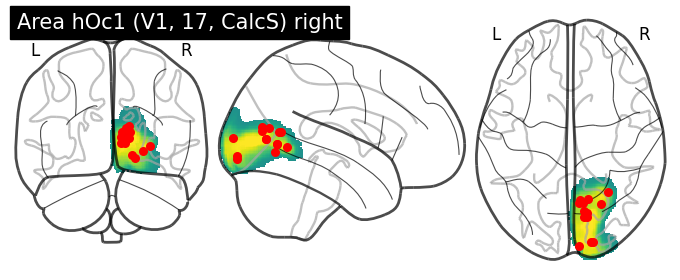

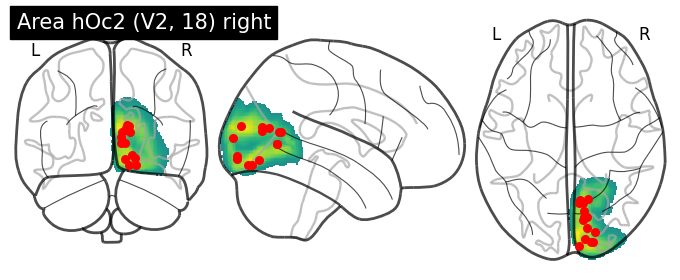

In [8]:
from nilearn import plotting

for regionname in candidate_regions:
    samples = jugex.get_samples(regionname)
    region = atlas.get_region(regionname)
    pmap = region.fetch_regional_map(
        siibra.spaces.MNI_152_ICBM_2009C_NONLINEAR_ASYMMETRIC, 
        siibra.MapType.STATISTICAL
    )    
    display = plotting.plot_glass_brain(pmap, cmap="viridis", title=region.name)
    display.add_markers([s['mnicoord'] for s in samples.values()])